# Parameter Estimation

Now, let's consider another scenario. Imagine another researcher sampled data every day, $x_{observed} = (x(t_1), x(t_2) , \ldots, x(t_n))$ and $y_{observed} = (y(t_1), y(t_2) , \ldots, y(t_n))$ where $t_1, t_2, \ldots, t_n$ represents time. The goal here is to determine the best values $\alpha$, $\beta$, $\gamma$ and $\delta$ for this sampled data.
$$
\dfrac{dx}{dt} = \alpha x - \beta xy \\
\dfrac{dy}{dt} = -\gamma y + \delta xy
$$
This is called an _Inverse Problem_ but some authors also called this sort of approaches as _Data-Driven Discovery_. We will use PINNs for this purpose and you will notice we only need to add some extra features compared to the last lesson.

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

from scipy.integrate import solve_ivp
from deepxde.backend import tf

Using backend: tensorflow.compat.v1

2023-03-15 16:03:13.508806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:03:13.775017: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 16:03:14.533531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/nc-bo

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-03-15 16:03:15.644455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:03:15.679285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:03:15.679322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Training Data

The train data will be generated by ourserlves, so we will have a better understading of the error. Let's choose a time interval, initial conditions and parameters.

In [2]:
t_initial, t_final = 0, 10  # Equivalent to 10 days
x0 = 1.2
y0 = 0.8

alpha_real = 2 / 3
beta_real = 4 / 3
gamma_real = 1
delta_real = 1

parameters_real = {
    "alpha": alpha_real,
    "beta": beta_real,
    "gamma": gamma_real,
    "delta": delta_real
}  # We will use this later for study errors

We can use a similar approach than last module for generate synthetic data, this will allows us to study errors.

In [3]:
def generate_data(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t = t.flatten()
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    return sol.y.T


Generate the synthetic data and plot it.

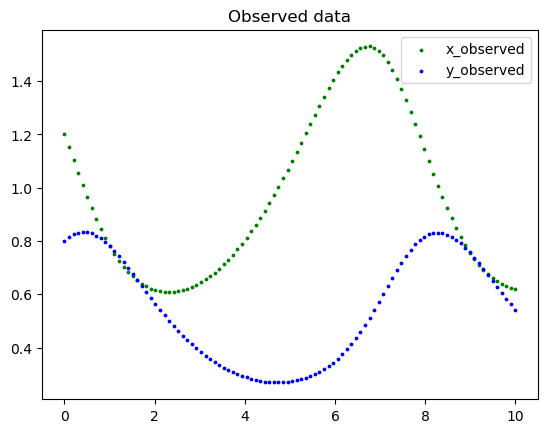

In [5]:
t_train = np.linspace(t_initial, t_final, 100).reshape(-1, 1)
Y_train = generate_data(t_train, x0, y0, alpha_real, beta_real, gamma_real, delta_real)

x_train = Y_train[:, 0:1]
y_train = Y_train[:, 1:2]
plt.scatter(t_train, x_train, color="green", s=3, label="x_observed")
plt.scatter(t_train, y_train, color="blue", s=3, label="y_observed")
plt.legend()
plt.title("Observed data")
plt.show()

## PINNs Data-Driven Discovery

Now we will _forget_ for a minute about the real values of $\alpha$, $\beta$, $\gamma$ and $\delta$ since the goal of this lesson is to learn how to estimate these parameters. Let's start defining them in a way that our code knows they have to be learned.

In [6]:
# Pick some initial guess

alpha = dde.Variable(0.0)
beta = dde.Variable(0.0)
gamma = dde.Variable(0.0)
delta = dde.Variable(0.0)

Now we have to define the residuals and initial conditions in the same way the forward approximation (previous module).

In [7]:
def ode(t, Y):
    x = Y[:, 0:1]
    y = Y[:, 1:2]
    dx_dt = dde.grad.jacobian(Y, t, i=0)
    dy_dt = dde.grad.jacobian(Y, t, i=1)
    
    return [
        dx_dt - alpha * x + beta * x * y,
        dy_dt + gamma * y  - delta * x * y
    ]

And also geometry and initial conditions

In [8]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

def boundary(_, on_initial):
    return on_initial

ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

We can use the observed data `t_train` and `Y_train`, which are equivalent to $x_{observed} = (x(t_1), x(t_2) , \ldots, x(t_n))$ and $y_{observed} = (y(t_1), y(t_2) , \ldots, y(t_n))$ for learning the values of our parameters. So we need to declare a new object and then include it to our model.

In [9]:
observe_x = dde.icbc.PointSetBC(t_train.reshape(-1, 1), Y_train[:, 0:1], component=0)
observe_y = dde.icbc.PointSetBC(t_train.reshape(-1, 1), Y_train[:, 1:2], component=1)

Be careful! Note that `component=0` is associated with the variable $x$ every time, defining the gradients, initial conditions and observed data. Same for `component=1` which corresponds to the variable $y$.

The data object is similar but we include the observed data as well in the list of conditions. But also note that we can add the observed data as train points with the argument `anchors`.

In [10]:
data = dde.data.PDE(
    geom,
    ode,
    [ic_x, ic_y, observe_x, observe_y],
    num_domain=512,
    num_boundary=2,
    anchors=t_train,
)

Now we can define our neural network

In [11]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

## Training

This step is also similar, except we have to tell our model it has to learn external variables ($\alpha$, $\beta$, $\gamma$ and $\delta$) using `external_trainable_variables`.

In [12]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.001,
    external_trainable_variables=[alpha, beta, gamma, delta]
)

Compiling model...
Building feed-forward neural network...
'build' took 0.038952 s



/home/alonsolml/mambaforge/envs/nc-book/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-15 16:03:16.828845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:03:16.830455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:03:16.830506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open fil

'compile' took 1.121173 s



In order to study the convergence of the learning process related to the parameters we want to estimate we need a separate file where we can store these estimations. The file `variables.dat` will store ours estimations of $\alpha$, $\beta$, $\gamma$ and $\delta$ each 100 iterations.

In [13]:
variable = dde.callbacks.VariableValue(
    [alpha, beta, gamma, delta],
    period=100,
    filename="variables.dat"
)

Do not forget to add this variable in the training process using `callbacks=[variable]`. 

In [14]:
losshistory, train_state = model.train(iterations=30000, display_every=5000, callbacks=[variable])
dde.utils.external.plot_loss_history(losshistory)

Initializing variables...
Training model...



2023-03-15 16:03:17.985705: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-15 16:03:18.096231: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3af4005790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-15 16:03:18.096263: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-15 16:03:18.119464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-15 16:03:18.438313: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-03-15 16:03:18.535545: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                      Test loss                                                       Test metric
0         [2.28e-03, 9.84e-04, 1.44e+00, 6.40e-01, 6.50e-01, 3.48e-01]    [2.28e-03, 9.84e-04, 1.44e+00, 6.40e-01, 6.50e-01, 3.48e-01]    []  


2023-03-15 16:03:19.157380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5000      [1.37e-05, 2.46e-06, 1.42e-08, 3.31e-08, 8.14e-06, 9.65e-06]    [1.37e-05, 2.46e-06, 1.42e-08, 3.31e-08, 8.14e-06, 9.65e-06]    []  
10000     [5.78e-05, 5.54e-05, 7.89e-05, 2.84e-07, 1.15e-04, 5.62e-05]    [5.78e-05, 5.54e-05, 7.89e-05, 2.84e-07, 1.15e-04, 5.62e-05]    []  
15000     [8.86e-05, 1.13e-04, 1.75e-04, 7.01e-06, 2.28e-04, 9.64e-05]    [8.86e-05, 1.13e-04, 1.75e-04, 7.01e-06, 2.28e-04, 9.64e-05]    []  
20000     [4.63e-05, 1.17e-05, 1.27e-05, 4.20e-07, 6.50e-06, 3.23e-05]    [4.63e-05, 1.17e-05, 1.27e-05, 4.20e-07, 6.50e-06, 3.23e-05]    []  
25000     [7.50e-06, 2.47e-06, 1.08e-07, 8.47e-09, 1.31e-05, 7.61e-06]    [7.50e-06, 2.47e-06, 1.08e-07, 8.47e-09, 1.31e-05, 7.61e-06]    []  
30000     [5.97e-06, 2.09e-06, 1.89e-07, 8.19e-07, 4.87e-05, 1.06e-05]    [5.97e-06, 2.09e-06, 1.89e-07, 8.19e-07, 4.87e-05, 1.06e-05]    []  

Best model at step 25000:
  train loss: 3.08e-05
  test loss: 3.08e-05
  test metric: []

'train' took 47.458635 s



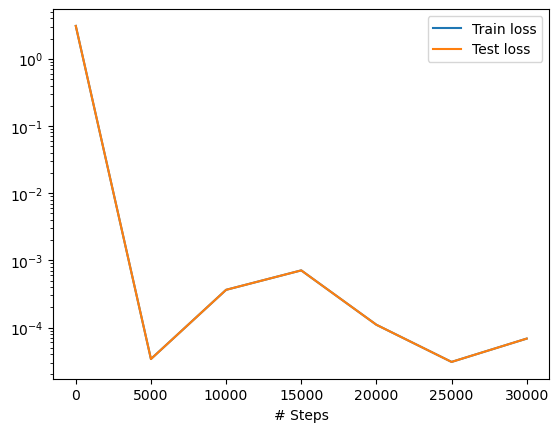

We can plot the data as well but it is not the main point of this lesson.

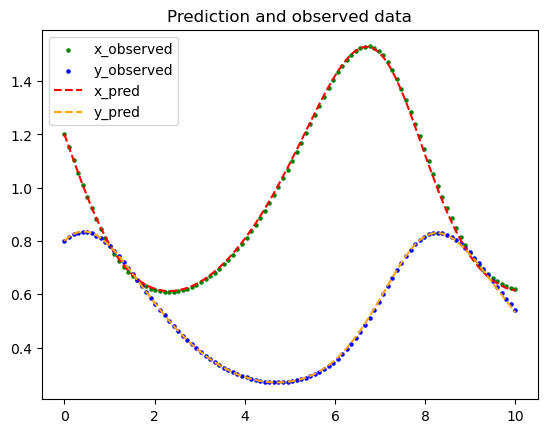

In [16]:
plt.scatter(t_train, x_train, color="green", s=5, label="x_observed")
plt.scatter(t_train, y_train, color="blue", s=5, label="y_observed")

sol_pred = model.predict(t_train.reshape(-1, 1))
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t_train, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t_train, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.title("Prediction and observed data")
plt.show()

## Learning History

We need to open the file `variables.dat` and create arrays for each parameter. Do not worry about the next piece of code, it will only return a dictionary where keys are the name of the parameters and values are their learning history. 

In [17]:
lines = open("variables.dat", "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
    name: raw_parameters_pred_history[:, i]
    for i, name in enumerate(parameters_real.keys())
}
parameters_pred_history.keys()

dict_keys(['alpha', 'beta', 'gamma', 'delta'])

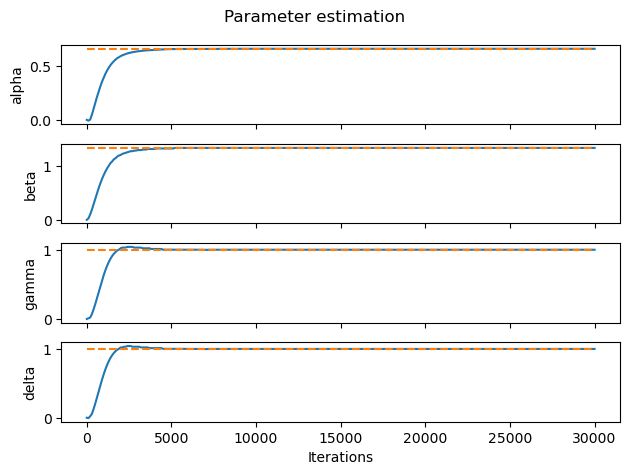

In [18]:
n_callbacis, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True)
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()

It took less than 5000 iterations to get a really good approximation for each variable! Now we can calculate the relative error for each parameter since we already know the real value.

In [19]:
alpha_pred, beta_pred, gamma_pred, delta_pred = variable.value

print(f"alpha - real: {alpha_real:4f} - predicted: {alpha_pred:4f} - relative error: {np.abs((alpha_real - alpha_pred) / alpha_real):4f}")
print(f"beta - real: {beta_real:4f} - predicted: {beta_pred:4f} - relative error: {np.abs((beta_real - beta_pred) / beta_real):4f}")
print(f"gamma - real: {gamma_real:4f} - predicted: {gamma_pred:4f} - relative error: {np.abs((gamma_real - gamma_pred) / gamma_real):4f}")
print(f"delta - real: {delta_real:4f} - predicted: {delta_pred:4f} - relative error: {np.abs((delta_real - delta_pred) / delta_real):4f}")

alpha - real: 0.666667 - predicted: 0.665105 - relative error: 0.002342
beta - real: 1.333333 - predicted: 1.330125 - relative error: 0.002406
gamma - real: 1.000000 - predicted: 0.999372 - relative error: 0.000628
delta - real: 1.000000 - predicted: 0.998206 - relative error: 0.001794
